In [1]:
%run supervised_functions.ipynb

Calculating probability for start mol sampling


100%|█████████████████████████████████████████████████████████| 69304/69304 [01:51<00:00, 621.25it/s]


# Generate data

In [2]:
np.random.seed(42)

N = 100000
steps = 5

In [3]:
def _generate_train_data(smile, steps):
    mol = Chem.MolFromSmiles(smile)

    df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product', 'step'])
    index = []
    
    # Get sequences
    try:
        for i in range(np.random.randint(steps+1, 15)):
            actions = get_applicable_actions(mol)
            if actions.shape[0] == 0:
                break

            # Apply a random action
            rand_idx = np.random.randint(0, actions.shape[0])
            product = apply_action(mol, *actions.iloc[rand_idx])

            # Add it to df
            df.loc[df.shape[0], :] = [Chem.MolToSmiles(mol)] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product), i]
            index.append(actions.iloc[rand_idx].name)

            # Next reactant = product
            mol = product
    except Exception as e:
        return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product', 'step'])
    
    # Fix index
    df.index = index
    
    # Fix target
    df["product"] = Chem.MolToSmiles(product)
    
    # Fix steps
    df["step"] = df.shape[0] - df["step"]
    
    return df[df['step'] <= steps]

def generate_train_data(N, steps, multiprocess=True):
    # Generate dataset
    df_list = []
    final_shape = 0
    smiles_per_random_sample = 1000
    pool_chunk_size = 10

    # Create dataset for multi-step pred
    print("Creating dataset...")
    if multiprocess:
        with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
            while final_shape < N:
                smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,), p=categorical_probs_for_sampling_start_mols)

                for new_df in p.imap_unordered(functools.partial(_generate_train_data, steps=steps), smiles, chunksize=10):
                    df_list.append(new_df)
                    final_shape += new_df.shape[0]

                pbar.update(final_shape - pbar.n)
    else:
        raise Exception("Single process not implemented... :'(")

    main_df = pd.concat(df_list)
    return main_df

# generate data
train_df = generate_train_data(int(N*0.8), steps)
test_df = generate_train_data(int(N*0.2), steps)
print(train_df.shape, test_df.shape)

# Randomize and concat 
main_df = pd.concat([train_df.sample(frac=1), test_df.sample(frac=1)])
print(main_df.shape)

Creating dataset...


84062it [12:34, 111.41it/s]                                                                          


Creating dataset...


23255it [03:26, 112.54it/s]                                                                          


(84062, 11) (23255, 11)
(107317, 11)


In [4]:
# remove 'step' (for backward compatibility)
main_df = main_df.drop(columns="step")

# Neural Network!

In [5]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [6]:
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

%time train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

Epoch 1, Loss: 23357.0547
Epoch 2, Loss: 13427.2109
Epoch 3, Loss: 4485.0420
Epoch 4, Loss: 1014.3859
Epoch 5, Loss: 385.7759
Epoch 6, Loss: 319.2338
Epoch 7, Loss: 310.9454
Epoch 8, Loss: 292.9850
Epoch 9, Loss: 292.2019
Epoch 10, Loss: 295.3425

FINAL TEST LOSS: 51.00959777832031
CPU times: user 6.99 s, sys: 910 ms, total: 7.9 s
Wall time: 3.95 s


NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

# Embedding type 2 - GIN training using attribute masking on clintox

In [4]:
model_name = "models/zinc2m_gin.pth"
gin_model = torch.load(model_name).to(device)

In [8]:
batch_size = 1024
X = []
for i in tqdm.tqdm(range(0, int(main_df.shape[0]*0.8), batch_size)):
    reactants = main_df["reactant"][i:i+batch_size]
    products = main_df["product"][i:i+batch_size]
    X.append(torch.concatenate([get_mol_embedding(gin_model, reactants), get_mol_embedding(gin_model, products)], axis=1))
X = torch.concatenate(X, axis=0)
emb_len = X.shape[1]//2
X.shape

  0%|                                                                         | 0/84 [00:00<?, ?it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
  1%|▊                                                                | 1/84 [00:07<10:21,  7.49s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
 18%|███████████▍                                                    | 15/84 [01:31<06:49,  5.94s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py

torch.Size([86016, 256])

In [9]:
Y = []
for i in tqdm.tqdm(range(0, int(main_df.shape[0]*0.8), batch_size)):
    Y.append(get_action_embedding(gin_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]]))
Y = torch.concatenate(Y)
Y.shape

100%|████████████████████████████████████████████████████████████████| 84/84 [03:02<00:00,  2.18s/it]


torch.Size([86016, 256])

### MSE training

In [10]:
model = train(X, Y, hidden_size=500, num_hidden=3, lr=1e-3, epochs=50)

Epoch 1, Loss: 0.1080
Epoch 2, Loss: 0.1004
Epoch 3, Loss: 0.0939
Epoch 4, Loss: 0.0887
Epoch 5, Loss: 0.0842
Epoch 6, Loss: 0.0806
Epoch 7, Loss: 0.0771
Epoch 8, Loss: 0.0735
Epoch 9, Loss: 0.0714
Epoch 10, Loss: 0.0696
Epoch 11, Loss: 0.0673
Epoch 12, Loss: 0.0656
Epoch 13, Loss: 0.0638
Epoch 14, Loss: 0.0625
Epoch 15, Loss: 0.0615
Epoch 16, Loss: 0.0604
Epoch 17, Loss: 0.0594
Epoch 18, Loss: 0.0572
Epoch 19, Loss: 0.0571
Epoch 20, Loss: 0.0557
Epoch 21, Loss: 0.0541
Epoch 22, Loss: 0.0534
Epoch 23, Loss: 0.0510
Epoch 24, Loss: 0.0499
Epoch 25, Loss: 0.0480
Epoch 26, Loss: 0.0471
Epoch 27, Loss: 0.0483
Epoch 28, Loss: 0.0477
Epoch 29, Loss: 0.0459
Epoch 30, Loss: 0.0455
Epoch 31, Loss: 0.0441
Epoch 32, Loss: 0.0430
Epoch 33, Loss: 0.0424
Epoch 34, Loss: 0.0419
Epoch 35, Loss: 0.0412
Epoch 36, Loss: 0.0406
Epoch 37, Loss: 0.0393
Epoch 38, Loss: 0.0385
Epoch 39, Loss: 0.0376
Epoch 40, Loss: 0.0370
Epoch 41, Loss: 0.0363
Epoch 42, Loss: 0.0371
Epoch 43, Loss: 0.0360
Epoch 44, Loss: 0.03

In [11]:
torch.save(model, f"models/supervised/mse_model/{steps}step.pth")

In [12]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

action_embeddings = get_action_dataset_embeddings(gin_model)
print(action_embeddings.shape)

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_

torch.Size([89384, 256])


### Back to modeling

In [13]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = []
correct_action_dataset_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_applicable_indices.append(correct_app_idx)
        correct_action_dataset_indices.append(correct_act_idx)

100%|███████████████████████████████████████████████████████| 107317/107317 [10:20<00:00, 172.92it/s]


In [14]:
pred = model(torch.Tensor(X[int(main_df.shape[0]*0.8):]).to(device)).detach()
l = []
total = []
for i in tqdm.tqdm(range(pred.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[int(main_df.shape[0]*0.8)+i]], correct_applicable_indices[int(main_df.shape[0]*0.8)+i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance="euclidean")
    l.append(rank.item())
    total.append(act_emb_for_i.shape[0])
print(f"{np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3071.52it/s]

106.1042944785276(236.09815950920245) +- 283.1148093223508  


In [15]:
train_idx = np.arange(0, int(X.shape[0]*0.8))
test_idx = np.arange(int(X.shape[0]*0.8), X.shape[0])

In [16]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)

CPU times: user 9min 30s, sys: 13 s, total: 9min 43s
Wall time: 9min 20s


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.22it/s]
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541035/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  


1.315710(1)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  1 │ 5.56936 │  0.710023 │         82.6085 │        250.332 │        278.368 │         76.0402 │        237.592 │        278.368 │ 6.08 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.66it/s]


BEST MODEL UPDATED! BEST RANK = 82.60850046641791
4.698608(2)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  2 │ 5.87075 │  0.724231 │         94.3714 │        267.076 │        278.368 │         87.4995 │        260.081 │        278.368 │ 6.20 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.55it/s]


5.027762(3)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  3 │ 5.63709 │  0.739785 │         97.9155 │        271.791 │        278.368 │          89.649 │        262.948 │        278.368 │ 6.13 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.67it/s]


9.212481(4)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  4 │ 5.49825 │  0.744706 │         101.988 │        277.077 │        278.368 │         93.6221 │        268.266 │        278.368 │ 6.05 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.29it/s]


9.532845(5)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  5 │ 5.50385 │  0.732984 │         101.485 │        274.405 │        278.368 │         90.8353 │        261.159 │        278.368 │ 6.01 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.43it/s]


10.023885(6)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  6 │ 5.42419 │  0.730066 │         101.872 │        273.904 │        278.368 │         90.2743 │        258.644 │        278.368 │ 5.99 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.14it/s]


10.174150(7)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  7 │ 5.21338 │  0.745753 │          102.74 │        277.157 │        278.368 │         92.3687 │        264.848 │        278.368 │ 6.03 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.61it/s]


8.958577(8)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  8 │ 5.16103 │  0.745586 │         102.738 │        277.086 │        278.368 │         92.2254 │        263.329 │        278.368 │ 5.92 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.83it/s]


8.728389(9)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  9 │ 5.16254 │   0.74079 │         103.025 │        278.624 │        278.368 │         92.5847 │        264.279 │        278.368 │ 6.00 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.49it/s]


7.868445(10)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 10 │ 5.14347 │  0.736501 │          103.09 │        277.631 │        278.368 │         92.4152 │        263.074 │        278.368 │ 6.03 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.67it/s]


7.051257(11)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 11 │ 5.02442 │  0.745266 │         103.674 │        278.431 │        278.368 │         93.6163 │        264.687 │        278.368 │ 6.01 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.09it/s]


8.892648(12)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 12 │ 5.08782 │  0.739862 │         105.548 │        279.785 │        278.368 │         94.3068 │        263.896 │        278.368 │ 6.13 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.53it/s]


6.929508(13)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 13 │ 5.10786 │  0.736689 │         104.217 │         279.42 │        278.368 │          93.354 │         266.82 │        278.368 │ 6.18 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.39it/s]


8.647192(14)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 14 │ 5.09908 │  0.733198 │         105.234 │        281.782 │        278.368 │         93.9337 │        266.041 │        278.368 │ 6.11 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.67it/s]


7.197935(15)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 15 │ 4.98765 │  0.738588 │         104.893 │        281.489 │        278.368 │         93.2394 │        265.818 │        278.368 │ 6.16 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.44it/s]


7.737230(16)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 16 │ 4.92886 │  0.742812 │         104.748 │        281.814 │        278.368 │         93.5612 │        266.353 │        278.368 │ 6.11 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.60it/s]


7.118981(17)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 17 │ 4.98916 │  0.734727 │         106.899 │        284.965 │        278.368 │         95.9341 │        271.995 │        278.368 │ 6.07 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.63it/s]


8.330336(18)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 18 │ 4.89703 │  0.737198 │         105.517 │        283.984 │        278.368 │         94.6668 │        269.385 │        278.368 │ 6.14 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.66it/s]


7.451024(19)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 19 │ 4.90162 │  0.735022 │         104.822 │         282.27 │        278.368 │         92.8316 │        264.943 │        278.368 │ 6.10 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.64it/s]


6.025070(20)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 20 │ 4.87613 │  0.735531 │         104.793 │        283.534 │        278.368 │         93.0609 │        267.176 │        278.368 │ 6.19 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.47it/s]


6.331342(21)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 21 │ 4.84486 │   0.73587 │         104.609 │        281.532 │        278.368 │         93.4008 │        267.653 │        278.368 │ 6.06 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.41it/s]


7.317247(22)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 22 │ 4.83774 │  0.736013 │         105.414 │        282.657 │        278.368 │         94.3693 │        268.666 │        278.368 │ 6.14 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.74it/s]


7.606679(23)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 23 │ 4.76815 │  0.740322 │         104.145 │        281.254 │        278.368 │          93.315 │        266.328 │        278.368 │ 6.16 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.80it/s]


7.078730(24)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 24 │ 4.81187 │  0.737903 │         104.504 │        281.225 │        278.368 │         92.7782 │        266.537 │        278.368 │ 6.16 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.04it/s]


6.635009(25)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 25 │ 4.81905 │  0.736083 │         104.321 │        280.808 │        278.368 │         93.1532 │        266.283 │        278.368 │ 6.08 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.78it/s]


7.691721(26)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 26 │ 4.85213 │  0.733068 │         105.138 │        283.436 │        278.368 │         93.3232 │        266.285 │        278.368 │ 6.18 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.44it/s]


7.809540(27)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 27 │ 4.89154 │   0.72913 │         104.741 │        281.621 │        278.368 │         93.2696 │        266.256 │        278.368 │ 6.10 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.63it/s]


6.648152(28)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 28 │ 4.91638 │   0.72751 │         104.825 │        282.136 │        278.368 │         93.4487 │        266.126 │        278.368 │ 6.13 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.30it/s]


6.980782(29)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 29 │ 4.86386 │  0.727709 │         103.743 │        279.792 │        278.368 │         92.7417 │        265.105 │        278.368 │ 6.15 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


7.914976(30)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 30 │ 4.71492 │  0.736562 │         104.093 │        281.345 │        278.368 │         93.1939 │        266.007 │        278.368 │ 6.00 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.32it/s]


6.424246(31)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 31 │ 4.84282 │  0.730876 │         104.114 │        280.818 │        278.368 │         92.9562 │         265.62 │        278.368 │ 6.18 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.43it/s]


6.870118(32)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 32 │ 4.83417 │  0.730278 │         104.699 │        282.131 │        278.368 │         93.0789 │         265.16 │        278.368 │ 6.06 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.82it/s]


6.186815(33)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 33 │ 4.75894 │  0.736486 │         104.248 │        282.093 │        278.368 │         92.3344 │        265.039 │        278.368 │ 6.12 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.72it/s]


9.125848(34)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 34 │ 4.81021 │  0.727512 │         103.835 │        281.607 │        278.368 │         91.7583 │         263.15 │        278.368 │ 6.08 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.82it/s]


7.121449(35)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 35 │ 4.87957 │   0.72498 │          104.39 │        281.023 │        278.368 │         92.7906 │        264.621 │        278.368 │ 6.17 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.84it/s]


7.417646(36)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 36 │ 4.82489 │  0.726391 │         104.047 │        282.201 │        278.368 │         92.7064 │        265.372 │        278.368 │ 6.13 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.57it/s]


6.662408(37)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 37 │ 4.85797 │   0.72322 │         104.236 │        281.713 │        278.368 │         92.9016 │         267.02 │        278.368 │ 6.05 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.42it/s]


6.841461(38)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 38 │ 4.74355 │  0.731707 │         103.431 │        280.372 │        278.368 │         90.9821 │        261.474 │        278.368 │ 6.18 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.27it/s]


6.464555(39)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 39 │ 4.76841 │  0.731786 │         102.174 │        278.369 │        278.368 │         89.1909 │        258.444 │        278.368 │ 6.15 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.67it/s]


6.893060(40)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 40 │ 4.78615 │  0.728716 │          102.48 │        278.789 │        278.368 │         90.0536 │        259.001 │        278.368 │ 6.20 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.61it/s]


10.043070(41)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 41 │ 4.83687 │  0.724083 │         103.957 │        281.386 │        278.368 │          90.864 │        260.329 │        278.368 │ 6.97 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.36it/s]


7.559011(42)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 42 │ 4.83652 │  0.722366 │           103.1 │        282.068 │        278.368 │         91.6088 │        264.033 │        278.368 │ 7.28 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.17it/s]


6.836725(43)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 43 │ 4.80734 │  0.724541 │         104.037 │        282.733 │        278.368 │         92.3011 │        265.865 │        278.368 │ 7.20 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.17it/s]


6.637659(44)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 44 │ 4.91492 │  0.716057 │         105.643 │        284.839 │        278.368 │         93.2239 │        266.371 │        278.368 │ 7.32 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:12<00:00,  3.46it/s]


9.825461(45)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 45 │ 4.81927 │  0.727275 │         103.059 │        280.246 │        278.368 │         91.2578 │        262.324 │        278.368 │ 7.15 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:11<00:00,  4.00it/s]


6.273266(46)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 46 │ 4.81649 │  0.723496 │         103.546 │        281.301 │        278.368 │         92.0724 │         265.45 │        278.368 │ 6.16 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.58it/s]


7.395914(47)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 47 │ 4.81129 │  0.724942 │         103.183 │        279.501 │        278.368 │         90.9646 │        260.438 │        278.368 │ 6.25 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.31it/s]


7.520034(48)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 48 │ 4.73953 │    0.7271 │           103.6 │        280.426 │        278.368 │         91.0462 │        261.723 │        278.368 │ 6.31 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:09<00:00,  4.46it/s]


6.811521(49)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 49 │ 4.76427 │  0.730611 │         102.987 │        280.791 │        278.368 │         91.3098 │        262.799 │        278.368 │ 6.91 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.13it/s]


7.451732(50)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 50 │ 4.85009 │  0.724993 │         102.869 │        279.539 │        278.368 │         90.8565 │        260.951 │        278.368 │ 6.30 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.10it/s]


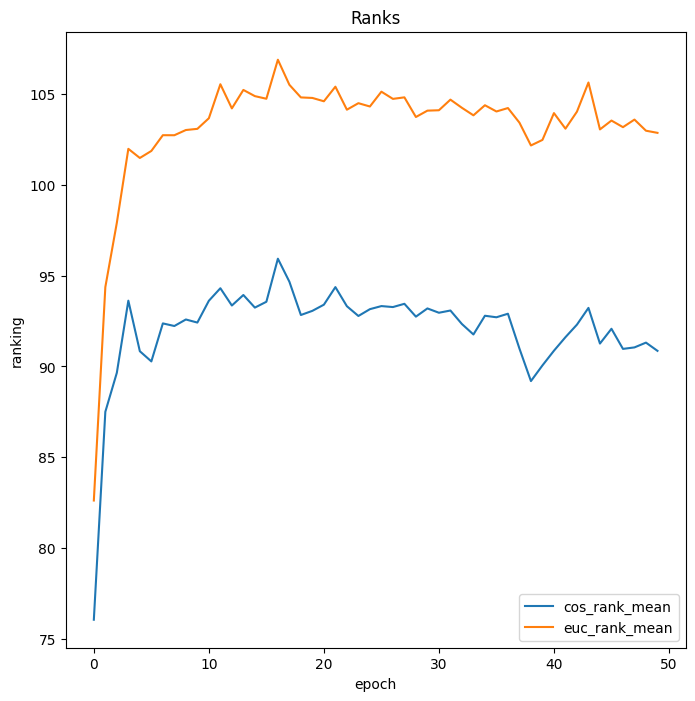

In [17]:
lr = 1e-3
epochs = 50
batch_size = 128


for distance_metric, negative_method, topk, emb_model_update in itertools.product(["euclidean"], ["all"], [10], [1]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    
    best_rank = 10000
    best_model = None
    
    model = PolicyNetwork().to(device)
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    criterion = WeightedRegularizedTriplet()
    
    action_embeddings = get_action_dataset_embeddings(embedding_model)
    action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)
    
    metric_dict = {"cos_rank_mean": [], "euc_rank_mean": [], "cos_rank_std": [], "euc_rank_std": [], 
                   "cos_rank_tot": [], "euc_rank_tot": [], "rmse": [], "cos_sim": [], "time(epoch_start-now)": []}
    # Train the model
    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
            outputs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size])

            # Calc negatives
            negatives = []
            
            for _i in range(outputs.shape[0]):
                curr_out = outputs[_i].detach()

                if negative_method == "applicable":
                    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_applicable_indices[train_idx[i+_i]]
                    top = get_top_k_indices(curr_out, act_emb_for_i, correct_applicable_index, distance=distance_metric, k=50)
                    negatives.append(act_emb_for_i[top])
                
                elif negative_method == "all":
                    correct_action_dataset_index = correct_action_dataset_indices[train_idx[i+_i]]
                    if distance_metric == "euclidean":
                        dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)
                    elif distance_metric == "cosine":
                        dist = (1 - action_embeddings.dot(curr_out)) / (action_embeddings_norm *torch.linalg.norm(curr_out))
                    sorted_idx = torch.argsort(dist)[:topk] # get topk
                    sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
                    negatives.append(action_embeddings[sorted_idx])
                        
            negatives = torch.Tensor(torch.concatenate(negatives, axis=0)).to(device)
                                
            # get targets
            targets = torch.Tensor(get_action_embedding(embedding_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]])).to(device)
                                
            # Calc loss
            inputs = torch.concat([outputs, targets, negatives])
            labels = torch.concat([torch.arange(outputs.shape[0]), torch.arange(targets.shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
            loss = criterion(inputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('{:.6f}({})'.format(loss.item(), epoch), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# emb_model_update = {emb_model_update} | -ve_method = {negative_method} | dist_metric = {distance_metric} | topk = {topk} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = torch.concatenate([model(test_reactants[i:i+batch_size], test_products[i:i+batch_size]).detach() for i in range(0, test_reactants.batch_size-batch_size, batch_size)], axis=0)
            true = get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])[:pred.shape[0]]

            metric_df = pd.DataFrame(columns=["rmse", "cos_sim", "euc_rank_mean", "euc_rank_std", "euc_rank_tot", "cos_rank_mean", "cos_rank_std", "cos_rank_tot", "time(epoch_start-now)"])

            # Print Test metrics
            metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean().item() )
            metric_dict["cos_sim"].append( ((pred*true).sum(axis=1) / torch.linalg.norm(pred, axis=1) / torch.linalg.norm(true, axis=1)).mean().item() )

            # Print Test metric - Rank
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_applicable_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance=dist)
                    l.append(rank.item())
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                metric_dict[f"{dist[:3]}_rank_mean"].append(np.mean(l))
                metric_dict[f"{dist[:3]}_rank_std"].append(np.std(l))
                metric_dict[f"{dist[:3]}_rank_tot"].append(np.mean(total))

            metric_dict["time(epoch_start-now)"].append(f"{(time.time()-start_time)/60:.2f} min")
            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
        # Update embedding model and action_embeddings
        if epoch % emb_model_update == 0:
            embedding_model.load_state_dict(model.GIN.state_dict())
            action_embeddings = get_action_dataset_embeddings(embedding_model)
            action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

        # Update best model
        if metric_dict["euc_rank_mean"][-1] < best_rank:
            best_rank = metric_dict["euc_rank_mean"][-1]
            best_model = type(model)()
            best_model.load_state_dict(model.state_dict())
            best_epoch = epoch
            print(f"BEST MODEL UPDATED! BEST RANK = {best_rank}")
            
    fig = plt.figure(figsize=(8, 8))
    for dist in filter(lambda x: "mean" in x, metric_dict.keys()):
        plt.plot(metric_dict[dist], label=dist)
    plt.title("Ranks")
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.legend()
    fig.show()
    
    # save everything
    folder = f"models/supervised/actor/{steps}step/emb_model_update={emb_model_update}||-ve_method={negative_method}||dist_metric={distance_metric}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
    fig.savefig(os.path.join(folder, "plot.png"))
    json.dump({
        "lr": lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "distance_metric": distance_metric,
        "negative_method": negative_method,
        "topk": topk,
        "emb_model_update": emb_model_update,
        "best_epoch": best_epoch,
        "best_rank": best_rank
    }, open(os.path.join(folder, "config.txt"), 'w'))